# Model Risk Exposure

By Evgenia "Jenny" Nitishinskaya and Delaney Granizo-Mackenzie.

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)

Notebook released under the Creative Commons Attribution 4.0 License.

---

##DISCLAIMER:

As always, this analysis is based on historical data, and risk exposures estimated on historical data may or may not affect the exposures going forward. As such, computing the risk exposure of to a factor is not enough. You must put confidence bounds on that risk exposure, and determine whether the risk exposure can even be modeled reasonably. For more information on this, please see our other lectures, especially Instability of Parameter Estimates.

##Using Factor Models to Determine Risk Exposure

We can use factor models to analyze the sources of risks and returns in portfolios. Recall that a factor model expresses the returns as

$$R_i = a_i + b_{i1} F_1 + b_{i2} F_2 + \ldots + b_{iK} F_K + \epsilon_i$$

By modelling the historical returns, we can see how much of them is due to speculation on different factors and how much to asset-specific fluctuations ($\epsilon_p$). We can also examine what sources of risk the portfolio is exposed to. 

In risk analysis, we often model active returns (returns relative to a benchmark) and active risk (standard deviation of active returns, also known as tracking error or tracking risk).

For instance, we can find a factor's marginal contribution to active risk squared (FMCAR). For factor $j$, this is

$$ \text{FMCAR}_j = \frac{b_j^a \sum_{i=1}^K b_i^a Cov(F_j, F_i)}{(\text{Active risk})^2} $$

where $b_i^a$ is the portfolio's active exposure (exposure different from the benchmark's) to factor $i$. This tells us how much risk we incur by being exposed to factor $j$, given all the other factors we're already exposed to.

Fundamental factor models are often used to evaluate portfolios because they correspond directly to investment choices (e.g. whether we invest in small-cap or large-cap stocks, etc.). Below, we construct a model to evaluate a single asset; for more information on the model construction, check out the fundamental factor models notebook.

We'll use the canonical Fama-French factors for this example, which are the returns of portfolios constructred based on fundamental factors.

##How many factors do you want?

In the Arbitrage Pricing Theory lecture we mention that for predictive models you want fewer parameters. However, this doesn't quite hold for risk exposure. Anything left over in our $\alpha$ is risk exposure that is currently unexplained by the selected factors. You want your strategy's return stream to be all alpha, and to be unexplained by as many parameters as possible. If you can show that your historical returns have little to no dependence on many factors, this is very positive.

## Setup

We'll do some setup work here. First we'll import libraries.

In [1]:
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels import regression
import matplotlib.pyplot as plt
import pandas as pd

Now we'll get monthly fundamental factor values.

In [2]:
start_date = '2014-01-01'
end_date = '2015-01-01'

# Get market cap and book value yield for all assets in universe
fundamentals = init_fundamentals()
# WARNING: The following line will take a while to run, as it is fetching a large amount of data.
# NOTE: We have to get 13 months worth of data. That is because we want the range Jan 14 - Jan 15, 
# which is actually 13 months of points.
cap_data = get_fundamentals(query(fundamentals.valuation.market_cap), end_date, range_specifier='13m')
# Drop missing data
cap_data = cap_data['market_cap'].T.dropna().T

bvy_data = get_fundamentals(query(fundamentals.valuation_ratios.book_value_yield), end_date, range_specifier='13m')
# Drop missing data
bvy_data = bvy_data['book_value_yield'].T.dropna().T
# Following the Fama-French model, ignore assets with negative book-to-price
bvy_data = bvy_data[bvy_data > 0]

## Factor Portfolio Returns

Often in factor analysis, instead of taking the raw values of the factor, we will examine the returns of a portfolio constructed on that factor. To construct a portfolio, most often we will rank all assets by the factor and go long the top and short the bottom. This is consistent with the methodology long-short equity strategies. The returns of this portfolio will be market neutral, and purely based on how well the factor seperates out high returns from low. This allows us to examine how the factor moves without having the market corrupt our analysis.

### Example

As an example of this, let's construct portfolios based on Market Cap and Book Value Yield.

First, we'll get corresponding pricing data for every asset in our fundamental data set.

In [3]:
# Get a list of all the assets we're dealing with
all_assets = set(bvy_data.columns).union(set(cap_data.columns))

# Get pricing on all the assets
prices = get_pricing(all_assets, start_date=start_date, end_date=end_date, fields='price')

# Compute returns from the price series
returns = prices.pct_change()[1:]

Now we'll try computing the factor portfolio returns for the first month in our data set. To do this we rank all the assets by market cap, then take the top 30% and bottom 30%. We compute the returns of a portfolio long the top and short the bottom.

In [4]:
# Rank the data by the factor for 
ranking = cap_data.iloc[0].rank()

# Compute which stocks are in the top and bottom of the ranking
top = ranking[ranking > np.percentile(ranking, 70)]
bottom = ranking[ranking < np.percentile(ranking, 30)]

top_returns = returns[cap_data.index[0]:cap_data.index[1]][top.index]
bottom_returns = returns[cap_data.index[0]:cap_data.index[1]][bottom.index]

factor_returns = np.mean(top_returns, axis=1) - np.mean(bottom_returns, axis=1)

print 'Factor portfolio returns'
print factor_returns

Factor portfolio returns
2014-01-03 00:00:00+00:00   -0.006214
2014-01-06 00:00:00+00:00   -0.011096
2014-01-07 00:00:00+00:00   -0.001804
2014-01-08 00:00:00+00:00   -0.002769
2014-01-09 00:00:00+00:00   -0.002623
2014-01-10 00:00:00+00:00   -0.000847
2014-01-13 00:00:00+00:00   -0.011002
2014-01-14 00:00:00+00:00    0.002248
2014-01-15 00:00:00+00:00   -0.004777
2014-01-16 00:00:00+00:00   -0.005924
2014-01-17 00:00:00+00:00   -0.007857
2014-01-21 00:00:00+00:00   -0.005921
2014-01-22 00:00:00+00:00   -0.002774
2014-01-23 00:00:00+00:00   -0.004273
2014-01-24 00:00:00+00:00   -0.004544
2014-01-27 00:00:00+00:00    0.007793
2014-01-28 00:00:00+00:00   -0.001325
2014-01-29 00:00:00+00:00   -0.005984
2014-01-30 00:00:00+00:00    0.002102
2014-01-31 00:00:00+00:00   -0.000694
2014-02-03 00:00:00+00:00   -0.006074
dtype: float64


Now we'll put that into a function so we can use it repeatedly to compute for all the months. 

NOTE: In this case we're updating the portfolio positions on a monthly basis. This is a design decision and may not be appropriate for computation of your factor returns. Some factors change more frequently and will require more frequent updating. You should test to see how different your return streams are with given update frequencies, and use that to guide the frequency you select.

In [5]:
def compute_month_of_factor_returns(data, returns, month_index, top_percentile = 70, bottom_percentile = 30):
    # Rank the data by the factor for 
    ranking = data.iloc[month_index].rank()
    
    # Compute which stocks are in the top and bottom of the ranking
    top = ranking[ranking > np.percentile(ranking, top_percentile)]
    bottom = ranking[ranking < np.percentile(ranking, bottom_percentile)]
    
    # Get returns for all stocks in the top and bottom
    top_returns = returns[data.index[month_index]:data.index[month_index+1]][top.index]
    bottom_returns = returns[data.index[month_index]:data.index[month_index+1]][bottom.index]
    
    # Compute factor portfolio returns = mean(top) - mean(bottom)
    factor_returns = np.mean(top_returns, axis=1) - np.mean(bottom_returns, axis=1)
    return factor_returns

Now let's compute the factor portfolio returns for each month and compile the full data set.

In [6]:
# Make an empty series
cap_factor_returns = pd.Series()

for m in range(12):
    factor_returns = compute_month_of_factor_returns(cap_data, returns, m)
    if m != 11:
        factor_returns = factor_returns[:-1]
    # Add to the main series
    cap_factor_returns = pd.concat([cap_factor_returns, factor_returns])

And again for book value yield.

In [7]:
bvy_factor_returns = pd.Series()
for m in range(12):
    factor_returns = compute_month_of_factor_returns(bvy_data, returns, m)
    if m != 11:
        factor_returns = factor_returns[:-1]
    bvy_factor_returns = pd.concat([bvy_factor_returns, factor_returns])

We now have the returns on a portfolio for each factor. Let's see how market cap looks.

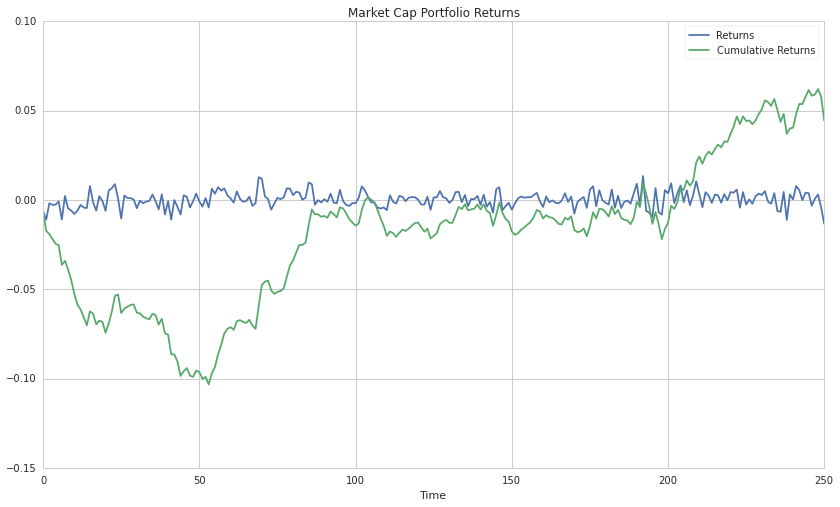

In [8]:
plt.plot(cap_factor_returns)
plt.plot(np.cumsum(cap_factor_returns))
plt.legend(['Returns', 'Cumulative Returns'])
plt.title('Market Cap Portfolio Returns')
plt.xlabel('Time');

## Computing Risk Exposure

Now we can determine how exposed another return stream is to each of these factors. We can do this by running static or rolling linear regressions between our return stream and the factor portfolio returns. First we'll compute the active returns (returns - benchmark) of some random asset and then model that asset as a linear combination of our two factors. The more a factor contributes to the active returns, the more exposed the active returns are to that factor.

In [9]:
f1 = cap_factor_returns
f2 = bvy_factor_returns

In [10]:
# Get returns data for our asset
asset = get_pricing('HSC', fields='price', start_date=start_date, end_date=end_date).pct_change()[1:]
bench = get_pricing('SPY', fields='price', start_date=start_date, end_date=end_date).pct_change()[1:]

# The excess returns of our active management, in this case just holding a portfolio of our one asset
active = asset - bench

# Define a constant to compute intercept
constant = pd.TimeSeries(np.ones(len(asset.index)), index=asset.index)

df = pd.DataFrame({'R': active,
              'F1': f1,
              'F2': f2,
              'Constant': constant})
df = df.dropna()

In [11]:
# Perform linear regression to get the coefficients in the model
b1, b2 = regression.linear_model.OLS(active, df[['F1', 'F2']]).fit().params

# Print the coefficients from the linear regression
print 'Sensitivities of active returns to factors:\nMarket cap: %f\nB/P: %f' %  (b1, b2)

Sensitivities of active returns to factors:
Market cap: 0.931092
B/P: -0.018724


Using the formula from the start of the notebook, we can compute the factors' marginal contributions to active risk squared:

In [12]:
cov = np.cov(f1, f2)
ar_squared = (active.std())**2
fmcar1 = (b1*(b2*cov[0,1] + b1*cov[0,0]))/ar_squared
fmcar2 = (b2*(b1*cov[0,1] + b2*cov[1,1]))/ar_squared
print 'Market Cap Risk Contribution:', fmcar1
print 'Book to Price Risk Contribution:', fmcar2

Market Cap Risk Contribution: 0.0696172902624
Book to Price Risk Contribution: 0.00026947689277


The rest of the risk can be attributed to active specific risk, i.e. factors that we did not take into account or the asset's idiosyncratic risk.

However, as usual we will look at how the exposure to these factors changes over time. As we lose a tremendous amount of information by just looking at one data point. Let's look at what happens if we run a rolling regression over time.

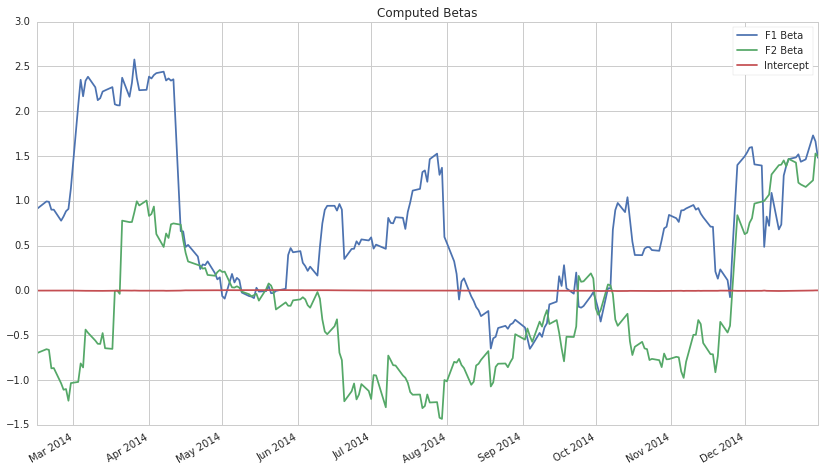

In [13]:
# Compute the rolling betas
model = pd.stats.ols.MovingOLS(y = df['R'], x=df[['F1', 'F2']], 
                             window_type='rolling', 
                             window=30)
rolling_parameter_estimates = model.beta
rolling_parameter_estimates.plot();
plt.title('Computed Betas');
plt.legend(['F1 Beta', 'F2 Beta', 'Intercept']);

Here we'll define a function to compute FMCAR for a given date.

In [14]:
active_risk_sqaured = pd.rolling_std(active, window = 30)**2
# Remove the first 30, which are all NaN
active_risk_sqaured = active_risk_sqaured[29:]

def compute_FMCAR(asset, bench, factor_df, factor_name, t, window = 30):
    # Transform to integer rather than date for indexing
    t = asset.index.get_loc(t)
    if t < window:
        return
    
    # Compute exess returns of the asset
    excess_returns = (asset-bench).iloc[t-window:t]
    # Compute the squared risk of the excess returns
    ar_squared = (excess_returns.std())**2
    
    # Compute the betas for the factors
    model = regression.linear_model.OLS(excess_returns, factor_df[t-window:t])
    fitted_model = model.fit()
    
    # Compute the bulk of FMCAR
    f_j = factor_df[factor_name].iloc[t-window:t]
    b_j = fitted_model.params[factor_name]
    s = 0.0
    for factor in factor_df:
        b_factor = fitted_model.params[factor]
        s += b_factor * np.cov(f_j, df[factor].iloc[t-window:t])[0, 1]
    return b_j * s / ar_squared

Now we'll compute it over our data on a rolling basis. We can see how the risk exposure to the different factors changes.

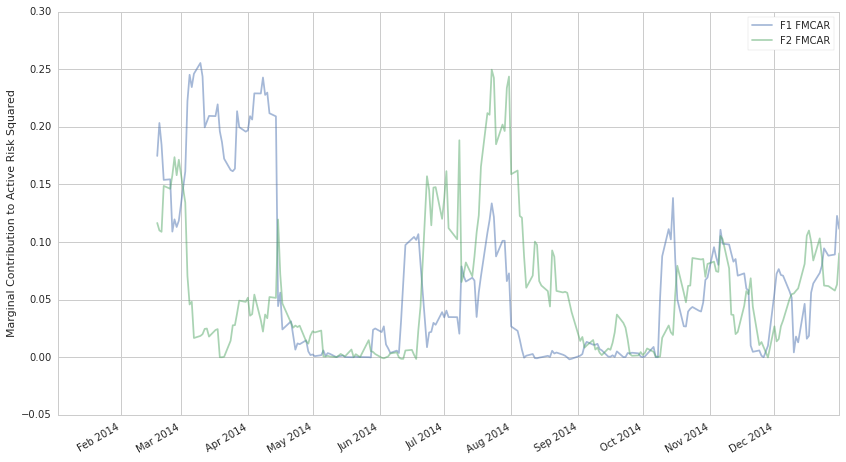

In [15]:
# Compute the FMCAR values for all timepoints
F1_FMCAR = [compute_FMCAR(asset, bench, df[['F1', 'F2', 'Constant']], 'F1', date, window=30) for date in asset.index]
F2_FMCAR = [compute_FMCAR(asset, bench, df[['F1', 'F2', 'Constant']], 'F2', date, window=30) for date in asset.index]

# Add the date index back in
F1_FMCAR = pd.TimeSeries(F1_FMCAR, index=asset.index)
F2_FMCAR = pd.TimeSeries(F2_FMCAR, index=asset.index)

# See how it looks
F1_FMCAR.plot(alpha=0.5)
F2_FMCAR.plot(alpha=0.5)
plt.ylabel('Marginal Contribution to Active Risk Squared')
plt.legend(['F1 FMCAR', 'F2 FMCAR']);

###Problems with using this data

We'd like to be able to make a meaningful statement about how exposued our asset is to these two factors, however, as you saw the exposure varies quite a bit, so taking the average is dangerous. We could put confidence intervals around that average, but that would only work if the distribution of exposures were normal. Let's check using our old buddy, the Jarque-Bera test.

In [16]:
from statsmodels.stats.stattools import jarque_bera
_, pvalue1, _, _ = jarque_bera(F1_FMCAR.dropna().values)
_, pvalue2, _, _ = jarque_bera(F2_FMCAR.dropna().values)

print 'p-value F1_FMCAR is normally distributed', pvalue1
print 'p-value F2_FMCAR is normally distributed', pvalue2

p-value F1_FMCAR is normally distributed 3.3301197293e-10
p-value F2_FMCAR is normally distributed 1.65839884108e-16


The p-values are below our default cutoff of 0.05. We can't even put good confidence intervals on the risk exposure of the asset, so making any statement about exposure in the future is very difficult right now. Any hedge we took out to cancel the exposure to one of the factors might be way over or under hedged.

We are trying to predict future exposure, and predicting the future is incredibly difficult. One must be very careful with statistical methods to ensure that false predictions are not made.

# Factor and tracking portfolios

We can use factor and tracking portfolios to tweak a portfolio's sensitivities to different sources of risk.

A <i>factor portfolio</i> has a sensitivity of 1 to a particular factor and 0 to all other factors. In other words, it represents the risk of that one factor. We can add a factor portfolio to a larger portfolio to adjust its exposure to that factor.

A similar concept is a <i>tracking portfolio</i>, which is constructed to have the same factor sensitivities as a benchmark or other portfolio. Like a factor portfolio, this allows us to either speculate on or hedge out the risks associated with that benchmark or portfolio. For instance, we regularly hedge out the market, because we care about how our portfolio performs relative to the market, and we don't want to be subject to the market's fluctuations.

To construct a factor or tracking portfolio, we need the factor sensitivities of what we want to track. We already know what these are in the former case, but we need to compute them in the latter using usual factor model methods. Then, we pick some $K+1$ assets (where $K$ is the number of factors we're considering) and solve for the weights of the assets in the portfolio.

##Portfolio Exposure

The portfolio exposure can be computed directly from the return stream, or as the weighted average of all the assets held.

## Example

Say we have two factors $F_1$ and $F_2$, and a benchmark with sensitivities of 1 and 1.1 to the factors, respectively. We identify 3 securities $x_1, x_2, x_3$ that we would like to use in composing a portfolio that tracks the benchmark, whose sensitivities  are $b_{11} = 0.7$, $b_{12} = 1.1$, $b_{21} = 0.1$, $b_{22} = 0.5$, $b_{31} = 1.5$, $b_{32} = 1.3$. We would like to compute weights $w_1$, $w_2$, $w_3$ so that our tracking portfolio is

$$ P = w_1 x_1 + w_2 x_2 + w_3 x_3 $$

We want our portfolio sensitivities to match the benchmark:

$$ w_1 b_{11} + w_2 b_{21} + w_3 b_{31} = 1 $$
$$ w_1 b_{12} + w_2 b_{22} + w_3 b_{32} = 1.1 $$

Also, the weights need to sum to 1:

$$ w_1 + w_2 + w_3 = 1 $$

Solving this system of 3 linear equations, we find that $w_1 = 1/3$, $w_2 = 1/6$, and $w_3 = 1/2$. Putting the securities together into a portfolio using these weights, we obtain a portfolio with the same risk profile as the benchmark.

##How to Use Risk Exposure Models

Once we know our risk exposures, we can do a few things. We can not enter into positions that have high exposures to certain factors, or we can hedge our positions to try to neutralize the exposure.

###Risk Management

Often times funds will have a layer of protection over their traders/algorithms. This layer of protection takes in the trades that the fund wants to make, then computes the exposure of the new portfolio, and checks to make sure they're within pre-defined ranges. If they are not, it does not place the trade and files a warning.

###Hedging

Another method of dealing with exposure is to take out hedges. You can determine, for example, your exposure to each sector of the market. You can then take out a hedge if a particular sector seems to affect your returns too much. For more information on hedging, please see our Beta Hedging lecture. Good algorithms will have built-in hedging logic that ensures they are never over-exposed.